## What we're going to do :

 - Retrieve data
 - Preparing the data
 - Build a model
 - Train the model
 - Evaluate the result

## A faire : 

- Sauvegarder modèles 
- Fonction pour refaire echantillon train / test à chque fois 
- TensorBoard

## 1 - Imports

In [3]:
import tensorflow
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from plot_keras_history import plot_history
import warnings
import random
#from keras import backend as K
#import tensorflow_probability as tfp
warnings.filterwarnings('ignore')

## 2 - Récupérer les données

In [2]:
data_river = pd.read_csv("../databases/HYDROSWOT_100m_V3.csv", sep=";")
display(data_river.head(5).style.set_caption("Few lines of the dataset :"))
print('Missing Data : ',data_river.isna().sum().sum(), '  Shape is : ', data_river.shape)

,site_no,station_name,river,stream_type,lon,lat,flowacc,stage,W,dH,dA,U,A0,Abar,Amed,Sdem,clay,sand,silt,PA,TA,LC1,LC2,LC3,LC4,LC5,LC6,LC7,LC8,LC9,LC10,LC11,LC12,Q5_GSCD,Q10_GSCD,Q20_GSCD,QMEAN_GSCD,Q80_GSCD,Q90_GSCD,Q95_GSCD,Q
0,2419890,TALLAPOOSA RIVER NEAR MONT.-MONT. WATER WORKS,TALLAPOOSA,river,-86.190000,32.430000,12033.084713,1.527048,125.882400,0.999744,106.723296,0.478536,100.144012,256.363762,190.883041,0.000983,18.801653,47.338843,33.834711,1391.111111,18.077047,8.809917,0.000000,6.289256,28.958678,1.256198,11.685950,36.950413,0.107438,5.958678,0.000000,0.000000,0.000000,46314.126839,27537.165438,16147.596327,5236103.019083,2545.144341,1831.073927,1303.980932,76.172317
1,2419890,TALLAPOOSA RIVER NEAR MONT.-MONT. WATER WORKS,TALLAPOOSA,river,-86.190000,32.430000,12033.084713,8.909304,152.095200,8.382000,1048.567348,1.405128,100.144012,256.363762,190.883041,0.000983,18.801653,47.338843,33.834711,1391.111111,18.077047,8.809917,0.000000,6.289256,28.958678,1.256198,11.685950,36.950413,0.107438,5.958678,0.000000,0.000000,0.000000,46314.126839,27537.165438,16147.596327,5236103.019083,2545.144341,1831.073927,1303.980932,1486.634446
2,2419890,TALLAPOOSA RIVER NEAR MONT.-MONT. WATER WORKS,TALLAPOOSA,river,-86.190000,32.430000,12033.084713,1.271016,116.433600,0.743712,77.334349,0.344424,100.144012,256.363762,190.883041,0.000983,18.801653,47.338843,33.834711,1391.111111,18.077047,8.809917,0.000000,6.289256,28.958678,1.256198,11.685950,36.950413,0.107438,5.958678,0.000000,0.000000,0.000000,46314.126839,27537.165438,16147.596327,5236103.019083,2545.144341,1831.073927,1303.980932,46.156460
3,2419890,TALLAPOOSA RIVER NEAR MONT.-MONT. WATER WORKS,TALLAPOOSA,river,-86.190000,32.430000,12033.084713,2.752344,112.166400,2.225040,248.776690,0.472440,100.144012,256.363762,190.883041,0.000983,18.801653,47.338843,33.834711,1391.111111,18.077047,8.809917,0.000000,6.289256,28.958678,1.256198,11.685950,36.950413,0.107438,5.958678,0.000000,0.000000,0.000000,46314.126839,27537.165438,16147.596327,5236103.019083,2545.144341,1831.073927,1303.980932,150.645624
4,2419890,TALLAPOOSA RIVER NEAR MONT.-MONT. WATER WORKS,TALLAPOOSA,river,-86.190000,32.430000,12033.084713,2.173224,120.396000,1.645920,180.287175,0.582168,100.144012,256.363762,190.883041,0.000983,18.801653,47.338843,33.834711,1391.111111,18.077047,8.809917,0.000000,6.289256,28.958678,1.256198,11.685950,36.950413,0.107438,5.958678,0.000000,0.000000,0.000000,46314.126839,27537.165438,16147.596327,5236103.019083,2545.144341,1831.073927,1303.980932,140.168391


Missing Data :  34   Shape is :  (16637, 41)


In [3]:
# Missing data = 34 => présence de valeurs NaN dans le tableau => on les retire
data_river.dropna(inplace=True)
display(data_river.head(5).style.set_caption("Few lines of the dataset :"))
print('Missing Data : ',data_river.isna().sum().sum(), 'Shape is : ', data_river.shape )

,site_no,station_name,river,stream_type,lon,lat,flowacc,stage,W,dH,dA,U,A0,Abar,Amed,Sdem,clay,sand,silt,PA,TA,LC1,LC2,LC3,LC4,LC5,LC6,LC7,LC8,LC9,LC10,LC11,LC12,Q5_GSCD,Q10_GSCD,Q20_GSCD,QMEAN_GSCD,Q80_GSCD,Q90_GSCD,Q95_GSCD,Q
0,2419890,TALLAPOOSA RIVER NEAR MONT.-MONT. WATER WORKS,TALLAPOOSA,river,-86.190000,32.430000,12033.084713,1.527048,125.882400,0.999744,106.723296,0.478536,100.144012,256.363762,190.883041,0.000983,18.801653,47.338843,33.834711,1391.111111,18.077047,8.809917,0.000000,6.289256,28.958678,1.256198,11.685950,36.950413,0.107438,5.958678,0.000000,0.000000,0.000000,46314.126839,27537.165438,16147.596327,5236103.019083,2545.144341,1831.073927,1303.980932,76.172317
1,2419890,TALLAPOOSA RIVER NEAR MONT.-MONT. WATER WORKS,TALLAPOOSA,river,-86.190000,32.430000,12033.084713,8.909304,152.095200,8.382000,1048.567348,1.405128,100.144012,256.363762,190.883041,0.000983,18.801653,47.338843,33.834711,1391.111111,18.077047,8.809917,0.000000,6.289256,28.958678,1.256198,11.685950,36.950413,0.107438,5.958678,0.000000,0.000000,0.000000,46314.126839,27537.165438,16147.596327,5236103.019083,2545.144341,1831.073927,1303.980932,1486.634446
2,2419890,TALLAPOOSA RIVER NEAR MONT.-MONT. WATER WORKS,TALLAPOOSA,river,-86.190000,32.430000,12033.084713,1.271016,116.433600,0.743712,77.334349,0.344424,100.144012,256.363762,190.883041,0.000983,18.801653,47.338843,33.834711,1391.111111,18.077047,8.809917,0.000000,6.289256,28.958678,1.256198,11.685950,36.950413,0.107438,5.958678,0.000000,0.000000,0.000000,46314.126839,27537.165438,16147.596327,5236103.019083,2545.144341,1831.073927,1303.980932,46.156460
3,2419890,TALLAPOOSA RIVER NEAR MONT.-MONT. WATER WORKS,TALLAPOOSA,river,-86.190000,32.430000,12033.084713,2.752344,112.166400,2.225040,248.776690,0.472440,100.144012,256.363762,190.883041,0.000983,18.801653,47.338843,33.834711,1391.111111,18.077047,8.809917,0.000000,6.289256,28.958678,1.256198,11.685950,36.950413,0.107438,5.958678,0.000000,0.000000,0.000000,46314.126839,27537.165438,16147.596327,5236103.019083,2545.144341,1831.073927,1303.980932,150.645624
4,2419890,TALLAPOOSA RIVER NEAR MONT.-MONT. WATER WORKS,TALLAPOOSA,river,-86.190000,32.430000,12033.084713,2.173224,120.396000,1.645920,180.287175,0.582168,100.144012,256.363762,190.883041,0.000983,18.801653,47.338843,33.834711,1391.111111,18.077047,8.809917,0.000000,6.289256,28.958678,1.256198,11.685950,36.950413,0.107438,5.958678,0.000000,0.000000,0.000000,46314.126839,27537.165438,16147.596327,5236103.019083,2545.144341,1831.073927,1303.980932,140.168391


Missing Data :  0 Shape is :  (16603, 41)


## 3 - Préparation des données
### 3.1 Suppresion des débits <100

In [4]:
data_river = data_river.loc[data_river['Q']>100]
data_river.head()

,site_no,station_name,river,stream_type,lon,lat,flowacc,stage,W,dH,...,LC11,LC12,Q5_GSCD,Q10_GSCD,Q20_GSCD,QMEAN_GSCD,Q80_GSCD,Q90_GSCD,Q95_GSCD,Q
1,2419890,TALLAPOOSA RIVER NEAR MONT.-MONT. WATER WORKS,TALLAPOOSA,river,-86.19,32.43,12033.084713,8.909304,152.0952,8.382000,...,0.0,0.0,46314.126839,27537.165438,16147.596327,5.236103e+06,2545.144341,1831.073927,1303.980932,1486.634446
3,2419890,TALLAPOOSA RIVER NEAR MONT.-MONT. WATER WORKS,TALLAPOOSA,river,-86.19,32.43,12033.084713,2.752344,112.1664,2.225040,...,0.0,0.0,46314.126839,27537.165438,16147.596327,5.236103e+06,2545.144341,1831.073927,1303.980932,150.645624
4,2419890,TALLAPOOSA RIVER NEAR MONT.-MONT. WATER WORKS,TALLAPOOSA,river,-86.19,32.43,12033.084713,2.173224,120.3960,1.645920,...,0.0,0.0,46314.126839,27537.165438,16147.596327,5.236103e+06,2545.144341,1831.073927,1303.980932,140.168391
5,2419890,TALLAPOOSA RIVER NEAR MONT.-MONT. WATER WORKS,TALLAPOOSA,river,-86.19,32.43,12033.084713,6.446520,131.9784,5.919216,...,0.0,0.0,46314.126839,27537.165438,16147.596327,5.236103e+06,2545.144341,1831.073927,1303.980932,826.851920
6,2419890,TALLAPOOSA RIVER NEAR MONT.-MONT. WATER WORKS,TALLAPOOSA,river,-86.19,32.43,12033.084713,2.154936,117.3480,1.627632,...,0.0,0.0,46314.126839,27537.165438,16147.596327,5.236103e+06,2545.144341,1831.073927,1303.980932,137.903043


In [5]:
print(data_river['river'])

1        TALLAPOOSA
3        TALLAPOOSA
4        TALLAPOOSA
5        TALLAPOOSA
6        TALLAPOOSA
            ...    
16624      SANGAMON
16628      SANGAMON
16629      SANGAMON
16633      SANGAMON
16635      SANGAMON
Name: river, Length: 12205, dtype: object


### 3.2 Séparer en 2 classes de rivières

In [6]:
river_means_hydro=data_river.groupby("river", as_index=False).mean()
river_medians_hydro=data_river.groupby("river", as_index=False).median
river_means_hydro['Q'].describe()

count     153.000000
mean      651.151533
std      1014.365708
min       102.554840
25%       300.855423
50%       414.091156
75%       636.758098
max      7888.527805
Name: Q, dtype: float64

In [7]:
river_LQ = river_means_hydro[river_means_hydro['Q']<=1000]
river_HQ = river_means_hydro[river_means_hydro['Q']>1000]
#print(river_HQ.describe())
#print(river_HQ['river'])
data_river_HQ = pd.concat([data_river[data_river['river']=="Arkansas"],data_river[data_river['river']=="Atchafalaya"],
                  data_river[data_river['river']=="CLARK FORK"],data_river[data_river['river']=="MISSISSIPPI"],
                  data_river[data_river['river']=="MISSOURI"],data_river[data_river['river']=="Mississippi"],
                  data_river[data_river['river']=="Missouri"],data_river[data_river['river']=="OHIO"],
                  data_river[data_river['river']=="PEND OREILLE"],data_river[data_river['river']=="St. John"],
                  data_river[data_river['river']=="Susquehanna"],data_river[data_river['river']=="TENNESSEE"],
                  data_river[data_river['river']=="TOMBIGBEE"]])
data_river_LQ = pd.concat([data_river, data_river_HQ]).drop_duplicates(keep=False)
#data_river_LQ = data_river_LQ.drop(index="Arkansas")
data_river_LQ.groupby('river', as_index=False).mean()

,river,site_no,lon,lat,flowacc,stage,W,dH,dA,U,...,LC11,LC12,Q5_GSCD,Q10_GSCD,Q20_GSCD,QMEAN_GSCD,Q80_GSCD,Q90_GSCD,Q95_GSCD,Q
0,White,7.076750e+06,-91.440000,35.120000,58015.733440,2.123747,147.272839,2.178611,315.017646,0.609884,...,0.000000,2.041322,2.655042e+05,1.462819e+05,70125.740269,2.823778e+07,4394.293110,1712.275232,2078.335276,516.416979
1,Arkansas,7.263450e+06,-92.350000,34.790000,409575.538158,71.018400,302.868965,0.676656,204.211114,0.697738,...,0.057851,4.694215,1.770777e+06,1.028122e+06,561058.220763,1.930410e+08,47065.486187,24893.263681,21835.388190,1699.087487
2,White,7.061000e+06,-91.640000,35.760000,28671.168267,2.705694,169.161210,2.038182,358.077793,0.584699,...,0.000000,1.049587,1.166473e+05,6.669244e+04,35570.672654,1.240842e+07,3072.781748,1962.647396,1703.264320,450.529548
3,ALABAMA,2.421838e+06,-86.651563,32.235000,42693.201966,7.511701,205.682850,1.414081,295.071639,0.462534,...,0.342201,2.900310,1.758510e+05,1.043391e+05,60050.651186,1.949534e+07,9884.076436,7101.755493,5184.564177,997.841429
4,ALTAMAHA,2.224940e+06,-82.510000,31.950000,29525.864340,3.102483,213.284753,3.129915,524.791054,0.771906,...,0.000000,0.528926,6.995469e+04,3.705967e+04,20689.627682,6.912112e+06,1922.593298,1052.930317,735.362334,632.816853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,White,7.058071e+06,-92.264179,36.195373,21948.409603,3.162641,151.129530,2.092702,322.981924,0.921269,...,0.000000,0.250154,7.520422e+04,4.510064e+04,26417.377913,8.262338e+06,2808.060442,1986.064781,1647.240345,656.263760
136,YAKIMA,1.250899e+07,-119.990000,46.230000,13879.746228,4.521591,108.412905,1.479687,155.630596,0.677359,...,0.000000,0.000000,1.197828e+03,7.722792e+02,475.322366,1.576484e+05,69.856676,49.371125,69.577206,258.685677
137,YAZOO,7.288800e+06,-90.810000,32.480000,32641.620024,16.972788,82.751676,1.885188,156.744845,0.704088,...,0.000000,0.231405,1.709466e+05,8.932603e+04,42634.123827,1.704775e+07,4728.377508,2694.802991,2727.786943,222.031828
138,Yellowstone,6.293611e+06,-106.249108,46.458089,117532.901128,5.705351,147.691481,0.866894,124.965622,1.047697,...,0.762647,2.614729,1.304497e+04,5.735896e+03,1336.137048,2.070029e+06,220.717573,171.255668,112.614690,462.128263


### 3.3 Choisir les données

In [8]:
to_drop = ['stream_type','A0','Abar','Amed','Sdem','stage','dA','site_no','lon','lat','station_name','U', 'Q5_GSCD','Q10_GSCD','Q20_GSCD','QMEAN_GSCD','Q80_GSCD','Q90_GSCD',
           'Q95_GSCD','LC1','LC2','LC3','LC4','LC5','LC6','LC7','LC8','LC9','LC10','LC11','LC12','clay','sand','silt','PA','TA']

# Pas U mais flowacc

# Pente du terrain

#Autre méthode
#columns_used=['date','pmer','tend','cod_tend','dd','ff','td','u','ww','pres','rafper','per','rr1','rr3','tc']

# ---- Drop unused columns

#to_drop = df.columns.difference(columns_used)
#df.drop( to_drop, axis=1, inplace=True)


data_LQ = data_river_LQ.drop(to_drop,axis=1)
data_HQ = data_river_HQ.drop(to_drop,axis=1)

display(data_LQ.head(5).style.set_caption("Few lines of the dataset :"))
print('Missing Data : ',data_LQ.isna().sum().sum(), '  Shape is : ', data_LQ.shape)

display(data_HQ.head(5).style.set_caption("Few lines of the dataset :"))
print('Missing Data : ',data_HQ.isna().sum().sum(), '  Shape is : ', data_HQ.shape)

,river,flowacc,W,dH,Q
1,TALLAPOOSA,12033.084713,152.095200,8.382000,1486.634446
3,TALLAPOOSA,12033.084713,112.166400,2.225040,150.645624
4,TALLAPOOSA,12033.084713,120.396000,1.645920,140.168391
5,TALLAPOOSA,12033.084713,131.978400,5.919216,826.851920
6,TALLAPOOSA,12033.084713,117.348000,1.627632,137.903043


Missing Data :  0   Shape is :  (6865, 5)


,river,flowacc,W,dH,Q
246,Arkansas,401448.155500,408.432000,4.142232,5266.933466
247,Arkansas,401448.155500,374.904000,4.892040,5436.834546
248,Arkansas,401448.155500,429.768000,5.806440,6852.676875
249,Arkansas,401448.155500,393.192000,1.981200,2392.773537
250,Arkansas,401448.155500,423.672000,0.000000,1787.982328


Missing Data :  0   Shape is :  (5022, 5)


### 3.2 Échantillons train et test

80% pour train - 20% pour test

x -> input data

y -> expected output

#### Petits débits

In [9]:
#nombre d'individus dans les 20%
n20 = data_LQ.shape[0]*0.2
print(n20) #1373

#Sélection rivière par rivière
LQrivers=river_LQ['river'].tolist()
LQ_test=pd.DataFrame(None)
while(LQ_test.shape[0]<n20):
    randomRiver=random.choice(LQrivers)
    LQrivers.remove(randomRiver)
    LQ_test=pd.concat([LQ_test,data_LQ[data_LQ['river']==randomRiver]])
LQrivers=river_LQ['river'].tolist()
    
LQ_train=pd.concat([data_LQ, LQ_test]).drop_duplicates(keep=False)
print(LQ_train)
print(LQ_test)

1373.0
          river       flowacc         W        dH            Q
32      ALABAMA  39075.150465  213.6648  0.957072   781.544966
35      ALABAMA  39075.150465  210.0072  0.585216   250.320924
36      ALABAMA  39075.150465  213.9696  2.511552  2310.654682
39      ALABAMA  39075.150465  184.7088  0.862584   756.059804
40      ALABAMA  39075.150465  209.0928  0.743712   770.218227
...         ...           ...       ...       ...          ...
16624  SANGAMON  13190.809393  113.3856  1.929384   213.225855
16628  SANGAMON  13190.809393  110.6424  1.938528   219.455561
16629  SANGAMON  13190.809393  108.5088  2.075688   238.144680
16633  SANGAMON  13190.809393  117.3480  3.133344   396.435852
16635  SANGAMON  13190.809393  105.1560  1.770888   190.572378

[5483 rows x 5 columns]
           river        flowacc            W        dH            Q
6525   Maquoketa    4840.687759   121.468896  3.983736   736.602449
12885     Neosho   15348.269481    86.868000  3.538728   628.633994
12886   

#### Grands débits

In [10]:
#nombre d'individus dans les 20%
n20 = data_HQ.shape[0]*0.2
print(n20) #1004

#Sélection rivière par rivière
HQrivers=river_HQ['river'].tolist()
HQ_test=pd.DataFrame(None)
while(HQ_test.shape[0]<n20):
    randomRiver2=random.choice(HQrivers)
    HQrivers.remove(randomRiver2)
    HQ_test=pd.concat([HQ_test,data_HQ[data_HQ['river']==randomRiver2]])
HQrivers=river_HQ['river'].tolist()
    
HQ_train=pd.concat([data_HQ, HQ_test]).drop_duplicates(keep=False)
print(HQ_train)
print(HQ_test)

1004.4000000000001
         river        flowacc         W        dH            Q
246   Arkansas  401448.155500  408.4320  4.142232  5266.933466
247   Arkansas  401448.155500  374.9040  4.892040  5436.834546
248   Arkansas  401448.155500  429.7680  5.806440  6852.676875
249   Arkansas  401448.155500  393.1920  1.981200  2392.773537
250   Arkansas  401448.155500  423.6720  0.000000  1787.982328
..         ...            ...       ...       ...          ...
620  TOMBIGBEE   47699.810838  197.5104  5.529072  1061.881747
621  TOMBIGBEE   47699.810838  170.6880  0.000000   242.392207
622  TOMBIGBEE   47699.810838  184.0992  2.435352   424.752699
623  TOMBIGBEE   47699.810838  188.3664  5.059680  1393.188852
624  TOMBIGBEE   47699.810838  199.9488  5.913120  1602.733517

[3944 rows x 5 columns]
             river       flowacc           W         dH             Q
14587    TENNESSEE  8.583221e+04  262.432800   1.246632   1493.713658
14588    TENNESSEE  8.583221e+04  287.426400   4.614672   27

In [11]:
# ---- Suffle and Split => train, test
def shuffle_river(data,river):
    
    #nombre d'individus dans les 20%
    n20 = data.shape[0]*0.2

    #Sélection rivière par rivière
    rivers=river['river'].tolist()
    data_test=pd.DataFrame(None)
    while(data_test.shape[0]<n20):
        randomRiver=random.choice(rivers)
        rivers.remove(randomRiver)
        data_test=pd.concat([data_test,data[data['river']==randomRiver]])
    rivers=river['river'].tolist()
    
    data_train=pd.concat([data, data_test]).drop_duplicates(keep=False)
    
    data_test=data_test.drop('river', axis=1)
    data_train=data_train.drop('river', axis=1)


    # ---- Split => x,y
    #
    x_train = data_train.drop('Q',  axis=1)
    y_train = data_train['Q'] 
    x_test  = data_test.drop('Q',   axis=1)
    y_test  = data_test['Q']


    #print('Original data shape was : ',data.shape)
    #print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
    #print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)
    
    return x_train, y_train , x_test, y_test

In [12]:
def shuffle(data): 
    
    data_train = data.sample(frac=0.8, axis=0) # peut être fait avec n = 'nombre de données voulues'
    data_test  = data.drop(data_train.index) # retire les données choisies
    #display(data_train.head())

    # ---- Split => x,y
    #
    x_train = data_train.drop('Q',  axis=1)
    y_train = data_train['Q'] 
    x_test  = data_test.drop('Q',   axis=1)
    y_test  = data_test['Q']


    #print('Original data shape was : ',data.shape)
    #print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
    #print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)
    
    return x_train, y_train , x_test, y_test

### 3.3 - Data normalization
**Note :** 
 - All input data must be normalized, train and test.  
 - To do this we will **subtract the mean** and **divide by the standard deviation**.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [13]:
def normalization(x_train,y_train,x_test,y_test):
    #display(x_train.describe().style.format("{0:.2f}").set_caption("Before normalization :"))

    mean = x_train.mean()
    std  = x_train.std()
    x_train = (x_train - mean) / std
    x_test  = (x_test  - mean) / std


    #mean = y_train.mean()
    #std  = y_train.std()

    #y_train = (y_train - mean) / std
    #y_test  = (y_test  - mean) / std

    #display(x_train.describe().style.format("{0:.2f}").set_caption("After normalization :"))
    #display(x_train.head(5).style.format("{0:.2f}").set_caption("Few lines of the dataset :"))

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test,  y_test  = np.array(x_test),  np.array(y_test)
    return x_train, y_train , x_test, y_test

# Step 4 - Build a model
About informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

### 4.1 Define custom metrics 

Pour implémenter : Pearson /  Low froude / NMRSE / KGE / NSE

- Normalized Root Mean Square Error $nRMSE(y) = \frac{RMSE(y)} {\bar y^{obs}}$


In [14]:
def nRMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))/K.mean(y_true)

- Nash-Sutcliffe model Efficiency $NSE(y) = 1 - \frac{\sum^n_{i=1}(y^{est}_i - y^{obs}_i)^2} {\sum^n_{i=1}(y^{obs}_i - \bar y^{obs})^2}$

In [15]:
def NSE(y_true, y_pred):
    return 1- K.mean(K.square(y_pred-y_true))/K.mean(K.square(y_true-K.mean(y_true)))

- Pearson correlation coefficient $R2(y) = \frac{\sum_{i=1}^{n}(y^{est}_i - \bar y^{est}) (y^{obs}_i - \bar y^{obs})} {\left(\sum_{i=1}^{n}(y^{est}_i - \bar y^{est})^2\right)^{1/2}\left(\sum_{i=1}^{n}(y^{obs}_i - \bar y^{obs})^2\right)^{1/2}}$

In [16]:
def R2(y_true,y_pred): 
    return tfp.stats.correlation(y_true, y_pred)

- Kling-Gupta model Efficiency $KGE(y) = 1 - \sqrt {(\beta_{KG}-1)^2+(\alpha_{KG}-1)^2+(R^2-1)^2}$, with $\beta_{KG}=\frac{\bar y^{est}}{\bar y^{obs}}$ and $\alpha_{KG} = \frac{\sigma(y^{est})}{\sigma(y^{obs})}$

In [17]:
def KGE(y_true,y_pred): 
    beta = K.mean(y_pred)/K.mean(y_true)
    alpha = K.var(y_pred)/K.var(y_true)
    r2 = R2(y_true,y_pred)
    kge = 1 - K.sqrt(K.square(beta-1) + K.square(alpha-1)+K.square(r2-1))
    return kge

### 4.2 Define a model

In [21]:
def get_model_v1(shape,n_layers,n_neurons): 
    
    # shape : nb de variables explicatives 
    # n_layers : nb de couches
    # n_neurons : neurons/ couche
   
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name="InputLayer"))
    
    for i in range(n_layers): 
            model.add(keras.layers.Dense(n_neurons, activation='relu', name='Dense_n'+str(i)))
   
    model.add(keras.layers.Dense(1, name='Output'))
    model.compile(optimizer = 'adam', 
                  loss      = 'mae',
                  metrics   = ['mae', 'mse'] )
    return model

## Step 5 - Train the model
### 5.1 - Get it

In [56]:
data_HQ.head()

,river,flowacc,W,dH,Q
246,Arkansas,401448.1555,408.432,4.142232,5266.933466
247,Arkansas,401448.1555,374.904,4.892040,5436.834546
248,Arkansas,401448.1555,429.768,5.806440,6852.676875
249,Arkansas,401448.1555,393.192,1.981200,2392.773537
250,Arkansas,401448.1555,423.672,0.000000,1787.982328


In [49]:
shape = 3
n_layers = 64
n_neurons = 64
model=get_model_v1((shape,),n_layers,n_neurons)

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_n0 (Dense)             (None, 64)                256       
_________________________________________________________________
Dense_n1 (Dense)             (None, 64)                4160      
_________________________________________________________________
Dense_n2 (Dense)             (None, 64)                4160      
_________________________________________________________________
Dense_n3 (Dense)             (None, 64)                4160      
_________________________________________________________________
Dense_n4 (Dense)             (None, 64)                4160      
_________________________________________________________________
Dense_n5 (Dense)             (None, 64)                4160      
_________________________________________________________________
Dense_n6 (Dense)             (None, 64)               

### 5.2 Train it

In [50]:
x_train, y_train , x_test, y_test = shuffle_river(data_HQ,river_HQ)
x_train, y_train , x_test, y_test = normalization(x_train,y_train,x_test,y_test)
ep = 100
history = model.fit(x_train,
                    y_train,
                    epochs          = ep,
                    batch_size = 50, 
                    verbose         = 0,
                    validation_data = (x_test, y_test))

## Step 6 - Evaluate
### 6.1 - Model evaluation
MAE =  Mean Absolute Error (between the labels and predictions)  
A mae equal to 3 represents an average error in prediction of $3k.

### 6.2 - Training history
What was the best result during our training ?

In [51]:
df=pd.DataFrame(data=history.history)
display(df.head().style.format("{0:.2f}").set_caption("Début du training:"))
display(df.tail().style.format("{0:.2f}").set_caption("Fin du training :"))

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error
0,1053.70,1053.70,4202882.00,2594.35,2594.35,20202592.00
1,434.51,434.51,1294279.25,2298.62,2298.62,15545775.00
2,293.46,293.46,795296.62,2167.74,2167.74,13299827.00
3,346.85,346.85,792444.75,2292.28,2292.28,15495129.00
4,278.73,278.73,691411.19,3096.54,3096.54,25741202.00


,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error
95,236.69,236.69,261713.56,1716.31,1716.31,7134209.50
96,169.80,169.80,178903.58,1689.93,1689.93,7185685.50
97,192.21,192.21,244104.64,1789.66,1789.66,7023692.00
98,182.95,182.95,176467.11,1557.57,1557.57,5636913.00
99,179.95,179.95,262499.62,1602.28,1602.28,6528790.00


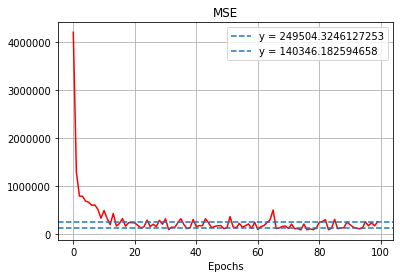

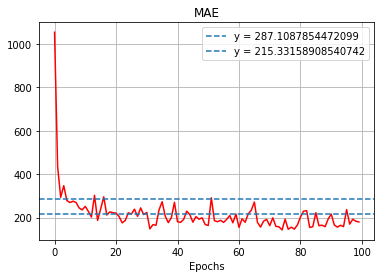

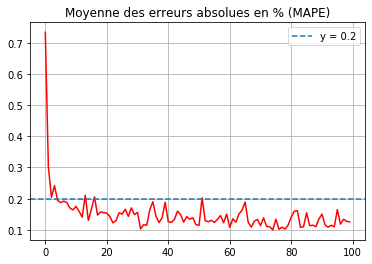

In [52]:
plt.plot(df['mean_squared_error'],'r')
plt.title('MSE')
plt.xlabel('Epochs')
plt.axhline(np.mean(y_train**2)*0.04,ls='--',label='y = ' + str(0.04*np.mean(y_train**2)))
plt.axhline(np.mean(y_train**2)*0.15**2,ls='--',label='y = ' + str(0.15**2*np.mean(y_train**2)))
plt.legend()
plt.grid()
plt.show()

plt.plot(df['mean_absolute_error'],'r')
plt.title('MAE')
plt.xlabel('Epochs')
plt.axhline(0.2*np.mean(y_train),ls='--',label='y = ' +str(0.2*np.mean(y_train)))
plt.axhline(0.15*np.mean(y_train),ls='--',label='y = ' +str(0.15*np.mean(y_train)))
plt.legend()
plt.grid()
plt.show()

plt.plot(df['mean_absolute_error']/np.mean(y_train),'r') # MAPE
plt.axhline(0.20,ls='--',label='y = 0.2')
plt.grid()
plt.title('Moyenne des erreurs absolues en % (MAPE)')
plt.legend()
plt.show()


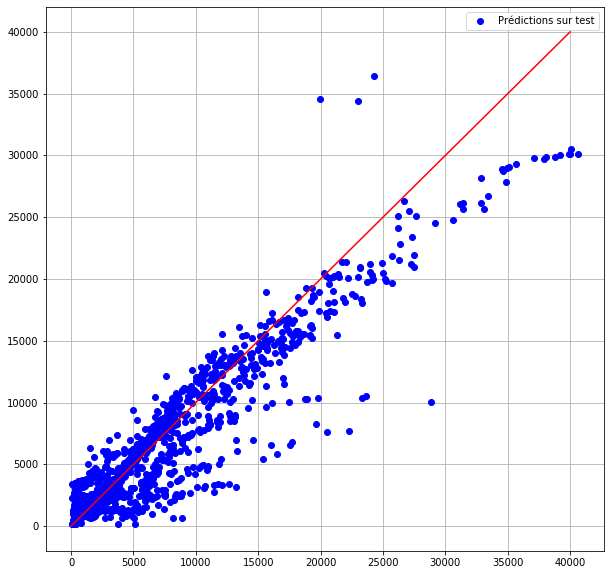

In [55]:
plt.figure(figsize=(10,10))
plt.plot(y_test,model.predict(x_test),'bo',label='Prédictions sur test')
x = np.arange(0,40000)
plt.plot(x,x,'r')
#plt.plot(x,x+0.20*x,'--g')
#plt.plot(x,x-0.20*x,'--g')
plt.legend()
plt.grid()
plt.show()

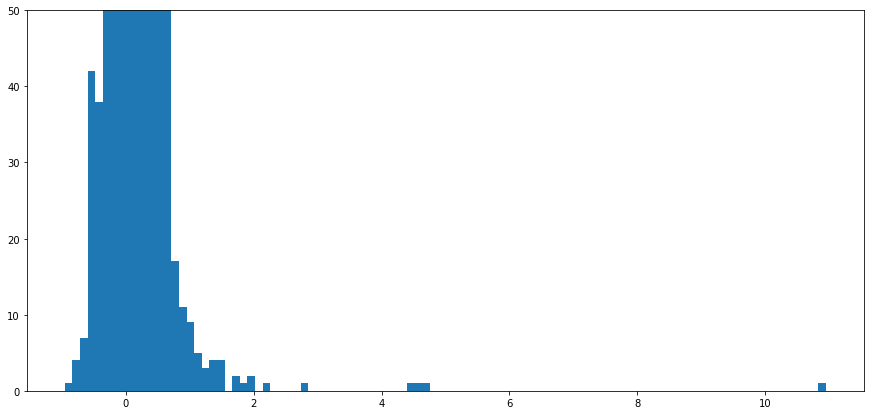

In [41]:
yt = y_test.reshape(y_test.shape[0],1)
plt.figure(figsize=(15,7))
plt.hist(((model.predict(x_test)-yt)/yt),bins=100)
plt.ylim(0,50)
plt.show()

Remarque : 

   - Avec toutes les données, on observe des valeurs aberrantes : vers +250 (250 000% d'erreur). Cela peut s'expliquer par la présence d'une rivière avec un très faible débit. 

   - Lorsqu'on enlève les débits <70, on a perdu environ 19% des données, on observe moins le phénomène des valeurs aberrantes. ( max : 15 ). 
    
   -  Lorsqu'on enlève les débits <100, on a perdu environ 26% des données, le max est maintenant de 6. 
    
Avec des valeurs de débits assez grandes, on arrive à limiter l'erreur relative

## Save the model

In [ ]:
model.save('../Models/model_'+str(n_layers)+'_'+str(n_neurons)+'_'+str(ep))

## Autre

In [ ]:
print("Weights and biases of the layers after training the model: \n")
for layer in model.layers:
    print("Layer : " , layer.name)
    print("Weights : ",layer.get_weights()[0].shape)
    print(layer.get_weights()[0])
    print("Bias")
    print("Shape: ",layer.get_weights()[1].shape,'\n',layer.get_weights()[1],'\n')